In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
tickers = ['SPY','TLT','IEF']
start_date = '2004-01-01'

panel_data = data.DataReader(tickers, 'yahoo', start_date)
close_data = panel_data.loc[:, ('Adj Close', slice(None))]
close_data.columns = close_data.columns.droplevel()
close_data.columns = tickers

#checking data
close_data.head()

,SPY,TLT,IEF
Date,,,
2004-01-02,79.052704,47.620655,52.621147
2004-01-05,79.912697,47.496597,52.577339
2004-01-06,79.990868,48.021038,52.971882
2004-01-07,80.260941,48.212833,53.090904
2004-01-08,80.580742,48.195904,53.090904


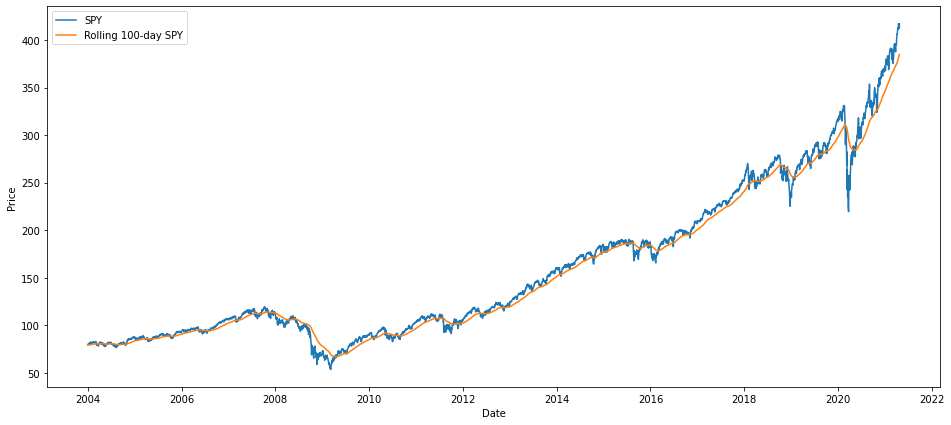

In [ ]:
# EMA as our indicator
window = 100
movavg = close_data.loc[:,'SPY'].ewm(span=window, adjust=False).mean() # EMA
spread = close_data['SPY'] - movavg

# Plotting out indicator on price chart
plt.figure(figsize=(16,7))
plt.plot(close_data['SPY'], label = 'SPY')
plt.plot(movavg.index, movavg, label = f'Rolling {window}-day SPY')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show();

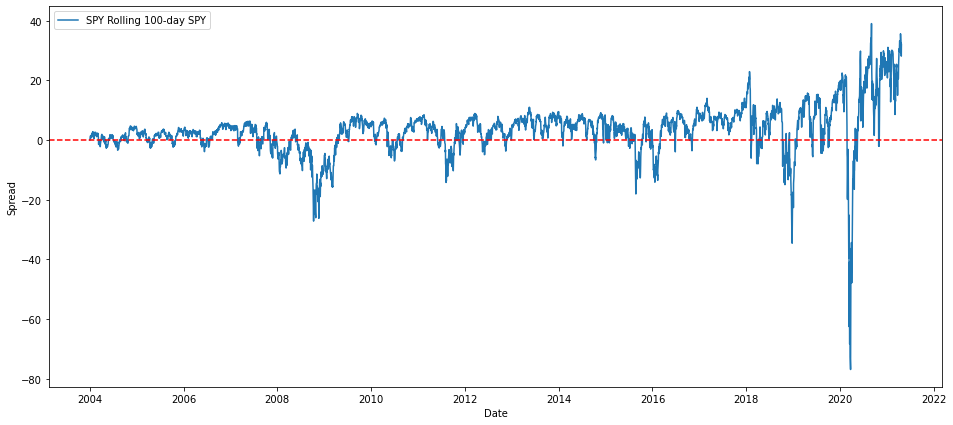

In [ ]:
#Transforming the plot the look to see how many times the price fell under EMA
plt.figure(figsize=(16,7))
plt.plot(spread.index, spread, label = f'SPY Rolling {window}-day SPY')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.axhline(color='r', ls ='--')
plt.legend(loc='best')
plt.show();

In [ ]:
# Trading metrics

#annualized percent return
def apr(ts):
  return np.prod(1 + ts) ** (252 / len(ts)) - 1

# sharpe ratio
def sharpe(ts):
  return np.sqrt(252) * np.mean(ts) / np.std(ts)

# max drawdown
def max_dd(ts):
  cum_ret = np.cumprod(1 + ts) - 1

  high_water_mark = np.zeros(cum_ret.shape)
  draw_down = np.zeros(cum_ret.shape)
  draw_down_duration = np.zeros(cum_ret.shape)

  for t in np.arange(1, cum_ret.shape[0]):
      high_water_mark[t] = np.maximum(high_water_mark[t - 1], cum_ret[t])
      draw_down[t] = (1 + cum_ret[t]) / (1 + high_water_mark[t]) - 1
      if draw_down[t] == 0:
          draw_down_duration[t] = 0
      else:
          draw_down_duration[t] = draw_down_duration[t - 1] + 1 # adds another day

  max_dd, i = np.min(draw_down), np.argmin(draw_down) # 'draw_down' < 0 always
  max_ddd = np.max(draw_down_duration)

  return max_dd, max_ddd, i

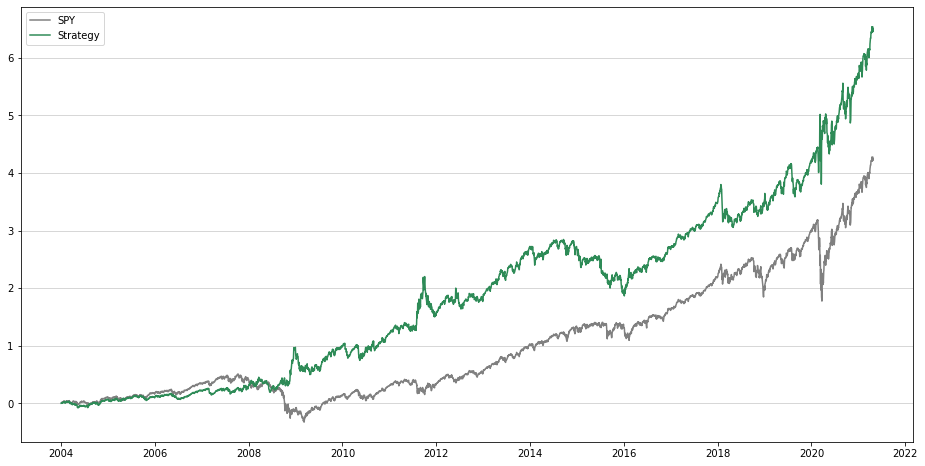

Asset		APR	Sharpe	Max DD	Max DDD
Strategy	12.39%	0.7804	-25.48%	606.0 days
Benchmark	10.09%	0.5981	-55.19%	1223.0 days


In [ ]:
# Unlevered trend following asset allocation

#signal - the price is above the spread and below the spread
signal = pd.DataFrame(index = movavg.index)
signal['above_movavg'] = close_data['SPY'] > movavg
signal['below_movavg'] = close_data['SPY'] < movavg
bmk_ret = close_data.pct_change()

#track our positions
pos = pd.DataFrame(index = movavg.index)
pos['SPY'] = 0
pos['TLT'] = 0
pos['IEF'] = 0

# Here we can change the leverage on the asset
pos.loc[signal['above_movavg'], 'SPY'] = 1
pos.loc[signal['below_movavg'], 'TLT'] = 1
pos.loc[signal['below_movavg'], 'IEF'] = 1

#set up a portfolio of assets
port = pd.DataFrame(index = movavg.index)
port['SPY'] = bmk_ret['SPY'] * pos['SPY'].shift()
port['TLT'] = bmk_ret['TLT'] * pos['TLT'].shift()
port['IEF'] = bmk_ret['IEF'] * pos['IEF'].shift()
port['port'] = port.sum(axis = 1)

#get the total returns of benchmark and strategy
cum_bmk_ret = np.cumprod(1 + bmk_ret.loc[start_date:, 'SPY']) - 1
cum_port_ret = np.cumprod(1 + port.loc[start_date:, 'port']) - 1

# Plotting returns against SPY - the benchmark
plt.figure(figsize = (16, 8))
plt.plot(cum_bmk_ret, label = 'SPY', color = 'gray')
plt.plot(cum_port_ret, label = 'Strategy', color = 'seagreen')
plt.legend(loc = 'best')
plt.grid(axis = 'y', lw = 0.5)
plt.show()

strat = port.loc[start_date:, 'port']
bmk = bmk_ret.loc[start_date:, 'SPY']

# performance metrics for strategy
strat_apr = apr(strat)
strat_sharpe = sharpe(strat)
strat_dd, strat_ddd, _ = max_dd(strat)

# performance metrics for benchmark
bmk_apr = apr(bmk)
bmk_sharpe = sharpe(bmk)
bmk_dd, bmk_ddd, _ = max_dd(bmk)

print('Asset\t\tAPR\tSharpe\tMax DD\tMax DDD')
print(f'Strategy\t{round(strat_apr * 100, 2)}%\t{round(strat_sharpe, 4)}\t{round(strat_dd * 100, 2)}%\t{strat_ddd} days')
print(f'Benchmark\t{round(bmk_apr * 100, 2)}%\t{round(bmk_sharpe, 4)}\t{round(bmk_dd * 100, 2)}%\t{bmk_ddd} days')

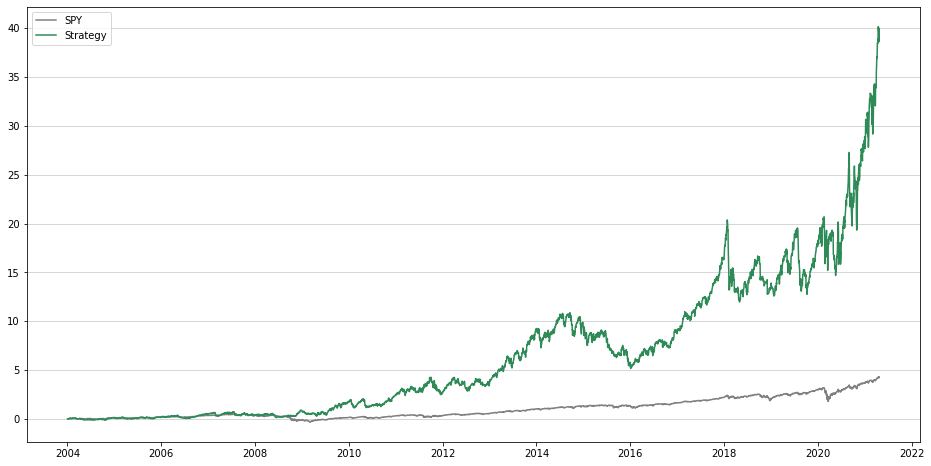

Asset		APR	Sharpe	Max DD	Max DDD
Strategy	23.96%	0.7846	-48.1%	615.0 days
Benchmark	10.09%	0.5981	-55.19%	1223.0 days


In [ ]:
# 3xSPY levered trend following asset allocation

#signal - the price is above the spread and below the spread
signal = pd.DataFrame(index = movavg.index)
signal['above_movavg'] = close_data['SPY'] > movavg
signal['below_movavg'] = close_data['SPY'] < movavg

bmk_ret = close_data.pct_change()

#track our positions
pos = pd.DataFrame(index = movavg.index)
pos['SPY'] = 0
pos['TLT'] = 0
pos['IEF'] = 0

# Here we can change the leverage on the asset
pos.loc[signal['above_movavg'], 'SPY'] = 3
pos.loc[signal['below_movavg'], 'TLT'] = 1
pos.loc[signal['below_movavg'], 'IEF'] = 1

#set up a portfolio of assets
port = pd.DataFrame(index = movavg.index)
port['SPY'] = bmk_ret['SPY'] * pos['SPY'].shift()
port['TLT'] = bmk_ret['TLT'] * pos['TLT'].shift()
port['IEF'] = bmk_ret['IEF'] * pos['IEF'].shift()
port['port'] = port.sum(axis = 1)

#get the total returns of benchmark and strategy
cum_bmk_ret = np.cumprod(1 + bmk_ret.loc[start_date:, 'SPY']) - 1
cum_port_ret = np.cumprod(1 + port.loc[start_date:, 'port']) - 1

plt.figure(figsize = (16, 8))
plt.plot(cum_bmk_ret, label = 'SPY', color = 'gray')
plt.plot(cum_port_ret, label = 'Strategy', color = 'seagreen')
plt.legend(loc = 'best')
plt.grid(axis = 'y', lw = 0.5)
plt.show()

strat = port.loc[start_date:, 'port']
bmk = bmk_ret.loc[start_date:, 'SPY']

# performance metrics for strategy
strat_apr = apr(strat)
strat_sharpe = sharpe(strat)
strat_dd, strat_ddd, _ = max_dd(strat)

# performance metrics for benchmark
bmk_apr = apr(bmk)
bmk_sharpe = sharpe(bmk)
bmk_dd, bmk_ddd, _ = max_dd(bmk)

print('Asset\t\tAPR\tSharpe\tMax DD\tMax DDD')
print(f'Strategy\t{round(strat_apr * 100, 2)}%\t{round(strat_sharpe, 4)}\t{round(strat_dd * 100, 2)}%\t{strat_ddd} days')
print(f'Benchmark\t{round(bmk_apr * 100, 2)}%\t{round(bmk_sharpe, 4)}\t{round(bmk_dd * 100, 2)}%\t{bmk_ddd} days')